# Tempering the Spread of Epidemics on Aerial Networks

## Students

* Team: `38`
* Students: `<Amaury Combes, Alexis Montavon, Manuel Faysse, Alexandre Daeniker>`
* Dataset: `<Flight Routes>`

## Motivation & Project Scenario

In this study we try to use network properties to find the appropriate way to mitigate the development of a widespread disease, without breaking down the network completely. With this aerial route network, two main idea will be developed: removing important edges and taking down nodes.

June 14, 2019: A new type of infectious disease breaks out and contaminates a small part of the population and. With every passing day, the epidemy spreads across the globe... This is the morbid scenario our project is meant to model. 
As we are working with flight routes, we model the infection rate of a country by the proportion on infected airports it has. The main idea is that the disease starts in Geneva Airport, chosen because it has a node degree of 100, which is much higher than the average degree (21.03), but is not as connected as a massive airport like Frankfurt (with degree 242). The infection has the ability to spread to $\approx 80\%$ the world in 200 days and stabilise near $81\%$ of infected persons in the population. The purpose of this study is to find a way to reduce the spreading as much as possible while having the smallest possible impact on the network.

## Data extraction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [134]:
# Your code here.
url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
#url = './airports.dat'
airports = pd.read_table(url, sep=',', delimiter=None, header=None)
airports.columns= ['Airport ID','Name', 'City','Country','IATA','ICAO','Lat','Long','Alt (feet)',
                   'Timezone','DST','Tz Database time zone','type','Source']
airports.head()  # the pandas dataframe with the features and labels

Airport ID                                         Name          City  \
0           1                               Goroka Airport        Goroka   
1           2                               Madang Airport        Madang   
2           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3           4                               Nadzab Airport        Nadzab   
4           5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO       Lat        Long  Alt (feet) Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998        5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001          20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005        5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977         239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001         146       10   U   

  Tz Database time zone     type       Source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports  
2  Pacific/Port_Moresby  airport  OurAirports  
3  Pacific/Port_Moresby  airport  OurAirports  
4  Pacific/Port_Moresby  airport  OurAirports

In [3]:
airports[airports['Airport ID'] == 340]

Airport ID                       Name       City  Country IATA  ICAO  \
336         340  Frankfurt am Main Airport  Frankfurt  Germany  FRA  EDDF   

           Lat      Long  Alt (feet) Timezone DST Tz Database time zone  \
336  50.033333  8.570556         364        1   E         Europe/Berlin   

        type       Source  
336  airport  OurAirports

In [4]:
url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat'
routes = pd.read_table(url, sep=',', delimiter=None, header=None)
routes.columns= ['Airline','Airline ID', 'Source Airport','Source_Airport_ID',
                 'Destination Airport', 'Destination_Airport_ID','Codeshare','Stops','Equipment']
routes.head(10)

Airline Airline ID Source Airport Source_Airport_ID Destination Airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   
5      2B        410            DME              4029                 KZN   
6      2B        410            DME              4029                 NBC   
7      2B        410            DME              4029                 TGK   
8      2B        410            DME              4029                 UUA   
9      2B        410            EGO              6156                 KGD   

  Destination_Airport_ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2  
5                   2990       NaN      0       CR2  
6                   6969       NaN      0       CR2  
7                     \N       NaN      0       CR2  
8                   6160       NaN      0       CR2  
9                   2952       NaN      0       CR2

In [5]:
routes2 = routes.copy()
airports2 = airports.copy()

In [6]:
edges = routes2[['Source_Airport_ID','Destination_Airport_ID']]
edges.Source_Airport_ID = pd.to_numeric(edges.Source_Airport_ID, 'coerce').dropna()
edges.Destination_Airport_ID = pd.to_numeric(edges.Destination_Airport_ID, 'coerce').dropna()
edges2 = edges.copy()
edges.head()

/Users/Alexis/anaconda/envs/ntds_2018/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Source_Airport_ID  Destination_Airport_ID
0             2965.0                  2990.0
1             2966.0                  2990.0
2             2966.0                  2962.0
3             2968.0                  2990.0
4             2968.0                  4078.0

In [7]:
airports2.reset_index(level=0, inplace=True)
airportID = airports2[['Airport ID', 'Name','City','Country']]
airportID.reset_index(inplace=True)  
airportID = airportID.rename(columns={'index':'airport_idx'})
airportID.head()

airport_idx  Airport ID                                         Name  \
0            0           1                               Goroka Airport   
1            1           2                               Madang Airport   
2            2           3                 Mount Hagen Kagamuga Airport   
3            3           4                               Nadzab Airport   
4            4           5  Port Moresby Jacksons International Airport   

           City           Country  
0        Goroka  Papua New Guinea  
1        Madang  Papua New Guinea  
2   Mount Hagen  Papua New Guinea  
3        Nadzab  Papua New Guinea  
4  Port Moresby  Papua New Guinea

In [8]:
ID2idx= airportID[['airport_idx', 'Airport ID']]
ID2idx = ID2idx.set_index('Airport ID')
ID2idx.head()

airport_idx
Airport ID             
1                     0
2                     1
3                     2
4                     3
5                     4

In [9]:
len(ID2idx)

7543

In [10]:
edges2 = edges.join(ID2idx, on='Source_Airport_ID', rsuffix='_source')
edges2 = edges2.join(ID2idx, on='Destination_Airport_ID', rsuffix='_dest')
edges2=edges2.dropna()

edges2.head()

Source_Airport_ID  Destination_Airport_ID  airport_idx  airport_idx_dest
0             2965.0                  2990.0       2809.0            2831.0
1             2966.0                  2990.0       2810.0            2831.0
2             2966.0                  2962.0       2810.0            2806.0
3             2968.0                  2990.0       2812.0            2831.0
4             2968.0                  4078.0       2812.0            3855.0

In [11]:
len(edges2)

66103

In [12]:
n_nodes = len(ID2idx)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

In [13]:
for idx, row in edges2.iterrows():
    if (np.isnan(row.airport_idx)):
        continue
    if (np.isnan(row.airport_idx_dest)):
        continue
    i, j = int(row.airport_idx), int(row.airport_idx_dest)
    adjacency[i, j] += 1

Text(0.5, 1.05, 'Adjacency matrix')

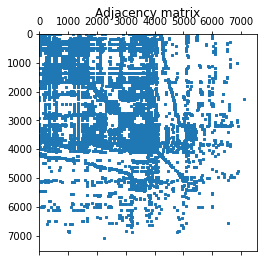

In [14]:
plt.spy(adjacency, markersize=2)
plt.title('Adjacency matrix')

#### Removing nodes with no edges

In [15]:
x = np.where(np.sum(adjacency, axis=1) > 0.0)

In [16]:
x[0]

array([   0,    1,    2, ..., 6881, 6885, 7089])

In [17]:
A = adjacency[x[0]]

In [18]:
A2 = A[:, x[0]]

Text(0.5, 1.05, 'Adjacency matrix')

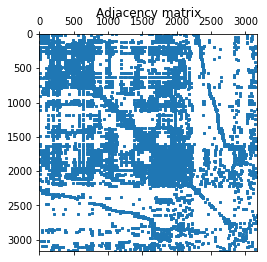

In [19]:
plt.spy(A2, markersize=2)
plt.title('Adjacency matrix')

In [20]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [21]:
check_symmetric(A2)

False

In [22]:
Mapping = dict(zip(range(len(x[0])), x[0]))

In [23]:
oldMap = ID2idx.to_dict()

In [24]:
oldMap2 = {value: key for key, value in list(oldMap.values())[0].items()}

In [25]:
Mapping2 = {value: key for key, value in Mapping.items()}

In [26]:
def indxToAirportID(x):
    return oldMap2[Mapping[x]]

In [27]:
indxToAirportID(0)

1

In [28]:
def AirportIDtoIndx(x):
    return Mapping2[list(oldMap.values())[0][x]]

In [29]:
AirportIDtoIndx(1665)

753

In [30]:
indxToAirportID(753)

1665

### Plot Airports On World Map (example with 300 airports)

In [31]:
import folium
from random import randint

In [32]:
airports2 = airports2.set_index('Airport ID')

In [33]:
rand = np.random.randint(3000, size=300)

In [34]:
m=folium.Map(
    location=[20, 0],
    tiles='Mapbox Bright',
    zoom_start=2
)


for i in rand:
    loc = airports2.loc[indxToAirportID(i)].Lat,airports2.loc[indxToAirportID(i)].Long
    popupName = airports2.Name[indxToAirportID(i)]
    folium.Marker(
    location=loc,
    popup=popupName,
    icon=folium.Icon(color='red',icon = 'plane')
).add_to(m)
    
m

## SIS simulation

In [35]:
import networkx as nx

### Create Graph, add weights and study some properties

In [36]:
G = nx.from_numpy_array(A2)

In [37]:
len(G.nodes)

3169

In [38]:
for edge in G.edges:
    G[edge[0]][edge[1]]['weight'] = A2[edge[0]][edge[1]]

In [39]:
G.get_edge_data(89, 125)

{'weight': 6}

In [40]:
#Using only giant connected component
giant_comp = max(nx.connected_component_subgraphs(G), key=len)

In [41]:
len(giant_comp.edges)

18587

In [44]:
#Diameter of the giant component
nx.diameter(giant_comp)

12

In [52]:
#Average shortest path of the giant component
nx.average_shortest_path_length(giant_comp)

3.949984334662642

In [83]:
def average_degree(g):
    return  sum(dict(g.degree(weight='weight')).values()) / len(g.nodes())

In [47]:
#Average degree of the giant component
average_degree(giant_comp)

21.037861915367483

### Configure simulation

In [42]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SISModel as sis
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend

output_notebook()

Loading BokehJS ...

In [43]:
def simulate_SIS(G, beta=0.01, lambda_=0.005, initial_node=753): ##GVA index
    model = sis.SISModel(G)
    
    cfg = mc.Configuration()
    infected_nodes = [initial_node]
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('lambda', lambda_)
    
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(800)
    
    trends = model.build_trends(iterations)
    
    return trends, iterations, model

In [123]:
trends, iterations, model = simulate_SIS(giant_comp)

In [124]:
viz = DiffusionTrend(model, trends)
p = viz.plot(width=500, height=500)
p.legend.location = "center_right"
show(p)

In [122]:
import folium
import geopandas as gpd
from branca.colormap import linear
from folium.plugins import TimeSliderChoropleth
import numpy as np
import os

datapath = 'world.geo.json'
gdf = gpd.read_file(datapath)

%matplotlib inline

def makeMap(iterations):
    dicofdic = {}

    checkpoints = range(0,800,20)

    for itera in checkpoints:
        dic = {}
        dicCountries = {}
        dicInfected = {}

        #itera = 100

        for i in range(itera):
            for key in iterations[i]['status']:
                dic[key] = iterations[i]['status'][key]

        for a in dic:
            if airports2.loc[indxToAirportID(a)]['Country'] in dicInfected:
                dicInfected[airports2.loc[indxToAirportID(a)]['Country']] += dic[a]
            else:
                dicInfected[airports2.loc[indxToAirportID(a)]['Country']] = dic[a]



        nodes = list(giant_comp)
        for a in nodes:
            if airports2.loc[indxToAirportID(a)]['Country'] in dicCountries:
                dicCountries[airports2.loc[indxToAirportID(a)]['Country']] += 1
            else:
                dicCountries[airports2.loc[indxToAirportID(a)]['Country']] = 1

        for key in dicCountries:
            if key in dicInfected:
                dicCountries[key] = dicInfected[key]/dicCountries[key]
            else:
                dicCountries[key] = 0

        dicofdic[itera]  = dicCountries  


    n_periods, n_sample = len(checkpoints),len(checkpoints)

    assert n_sample <= n_periods

    datetime_index = pd.date_range('2019-1-1', periods=n_periods, freq='20D')
    dt_index_epochs = datetime_index.astype(int) // 10**9
    dt_index = dt_index_epochs.astype('U10')

    styledata = {}

    for country in gdf.index:

        vec = []
        for i in checkpoints:
            try:
                vec.append(dicofdic[i][gdf.loc[country]['name']])
            except:
                vec = 0*np.ones(len(checkpoints))

        df = pd.DataFrame(
            {'color': np.array(vec)*10 ,
             'opacity': 0.5*np.ones(len(checkpoints))},
            index=dt_index
        )
        #df = df.cumsum()
        df.sample(n_sample, replace=False).sort_index()
        styledata[country] = df



    max_color, min_color, max_opacity, min_opacity = 0, 0, 0, 0

    for country, data in styledata.items():
        max_color = max(max_color, data['color'].max())
        min_color = min(max_color, data['color'].min())
        max_opacity = max(max_color, data['opacity'].max())
        max_opacity = min(max_color, data['opacity'].max())



    cmap = linear.YlOrRd_09.scale(min_color, max_color)


    def norm(x):
        return (x - x.min()) / (x.max() - x.min())


    for country, data in styledata.items():
        data['color'] = data['color'].apply(cmap)

    styledict = { str(country): data.to_dict(orient='index') for country, data in styledata.items()}

    m = folium.Map([0, 0], tiles='OpenStreetMap', zoom_start=2)

    g = TimeSliderChoropleth(
        gdf.to_json(),
        styledict=styledict,

    ).add_to(m)

    m.save(os.path.join('TimeSliderChoropleth.html'))

    return m

### Epidemic visualisation by country

In [125]:
makeMap(iterations)

## Mitigate the infection

In [48]:
from tqdm import tqdm_notebook

In [49]:
def plot_trends(trends):
    viz = DiffusionTrend(model, trends)
    p = viz.plot(width=500, height=500)
    p.legend.location = "center_right"
    show(p)


def extract_final_state(trends):
    return trends[0]['trends']['node_count'][0][-1], trends[0]['trends']['node_count'][1][-1]


def extract_suspected_count_history(trends):
    return trends['trends']['node_count'][0]


def extract_infection_states(experiment_history):
    infection_states = [(alteration_lvl, final_state[1] / (final_state[0] + final_state[1]))\
                        for alteration_lvl, graph, final_state, trends in experiment_history]
    
    return infection_states

In [50]:
simulate_e1_SIS = lambda G, initial_node: simulate_SIS(G, beta=0.01, lambda_=0.005, initial_node=initial_node)

In [51]:
def spread_reduction_experiment(G, simulateSIS, experiment_count, sample_count, alterator, initial_node):
    history = []
    
    alterator.register(G)
    
    for i in tqdm_notebook(range(experiment_count)):
        altered_G, alteration_level = alterator.alter(G, i, initial_node)
        
        logs = [simulateSIS(altered_G, initial_node)[0] for j in range(sample_count)]
        
        average_final_state = np.mean([extract_final_state(log) for log in logs], axis=0)
        
        history += [(alteration_level, altered_G, average_final_state, logs[-1])]
        
    return history

### Removing nodes by degree

In [52]:
class SimpleAlterator: 
        
    def register(self, G):
        degree_per_node = G.degree()
    
        self.ranked_nodes = sorted(dict(degree_per_node).keys(),\
                      key=lambda node: -degree_per_node[node])
        
    def alter(self, G, i, initial_node):
        tmp_G = G.copy()
    
        alteration_level = 50*i
        for node in self.ranked_nodes[:alteration_level]:
            if node != initial_node:
                tmp_G.remove_node(node)

        return tmp_G, alteration_level

In [53]:
simple_history = spread_reduction_experiment(giant_comp, simulate_e1_SIS, 20, 10, SimpleAlterator(), 753)

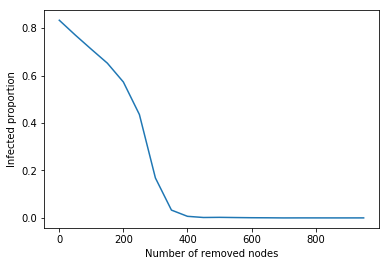

In [54]:
final_infection_states = np.array(extract_infection_states(simple_history))

plt.plot(final_infection_states[:,0], final_infection_states[:,1])
plt.xlabel('Number of removed nodes')
plt.ylabel('Infected proportion')
plt.show()

As we can see on the plot above, removing nodes with high degree is an effective strategy. Indeed, after removing 400 nodes with high degree, the epidemic will always die after 500 iterations. 


### Removing nodes without breaking connectivity
#### Removing by degree

Even though the suggested strategy above works, it is very restrictive as the graph is not connected anymore and we thus loose the full power of the aerial network. In the following, we will explore a few alteration strategies that preserves the connectedness property of our network while reducing the epidemic’s spread. The first strategy will remove nodes based on their degree, the second on the closeness value and the third on the betweenness value. But those times the graph will still be connected, so anyone can go from any airport to any other.

In [55]:
class ByDegreeAlterator: 
        
    def register(self, G):
        degree_per_node = G.degree()
    
        self.ranked_nodes = sorted(dict(degree_per_node).keys(),\
                      key=lambda node: -degree_per_node[node])
        
    def alter(self, G, i, initial_node):
        tmp_G = G.copy()
    
        alteration_level = 50*i
    
        for node in self.ranked_nodes[:alteration_level]:
            edges = list(tmp_G.edges(node))

            if node != initial_node:
                tmp_G.remove_node(node)

            if not nx.is_connected(tmp_G):
                    tmp_G.add_node(node)
                    tmp_G.add_edges_from(edges)

        return tmp_G, alteration_level

In [56]:
by_degree_history = spread_reduction_experiment(giant_comp, simulate_e1_SIS, 20, 10, ByDegreeAlterator(), 753)

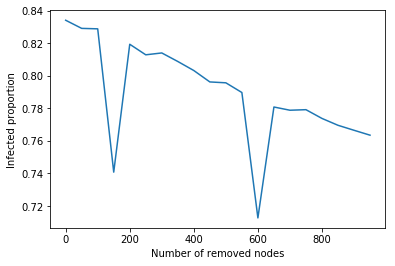

In [57]:
final_infection_states = np.array(extract_infection_states(by_degree_history))

plt.plot(final_infection_states[:,0], final_infection_states[:,1])
plt.xlabel('Number of removed nodes')
plt.ylabel('Infected proportion')
plt.show()

Here for comparison the simulation with 900 nodes removed, we can see that in the same amount of iterations, the virus only infects about 6% less of the globe

In [126]:
new_g = by_degree_history[-1][1]
trends, iterations, model = simulate_SIS(new_g)
viz = DiffusionTrend(model, trends)
p = viz.plot(width=500, height=500)
p.legend.location = "center_right"
show(p)

In [118]:
nx.diameter(new_g)

24

In [119]:
nx.average_shortest_path_length(new_g)

4.718146949071004

In [120]:
average_degree(new_g)

4.823055219669488

In [127]:
makeMap(iterations)

#### Removing by closeness

In [68]:
class ByClosenessAlterator: 
        
    def register(self, G):
        closeness_centrality_per_node = nx.closeness_centrality(G)
    
        self.ranked_nodes = sorted(dict(closeness_centrality_per_node).keys(),\
                      key=lambda node: -closeness_centrality_per_node[node])
        
    def alter(self, G, i, initial_node):
        tmp_G = G.copy()
    
        alteration_level = 50*i
    
        for node in self.ranked_nodes[:alteration_level]:
            edges = list(tmp_G.edges(node))

            if node != initial_node:
                tmp_G.remove_node(node)

            if not nx.is_connected(tmp_G):
                    tmp_G.add_node(node)
                    tmp_G.add_edges_from(edges)

        return tmp_G, alteration_level

In [69]:
by_closeness_history = spread_reduction_experiment(giant_comp, simulate_e1_SIS, 20, 10, ByClosenessAlterator(), 753)

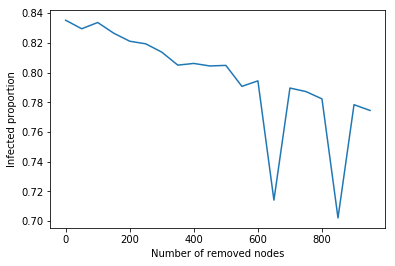

In [70]:
final_infection_states = np.array(extract_infection_states(by_closeness_history))

plt.plot(final_infection_states[:,0], final_infection_states[:,1])
plt.xlabel('Number of removed nodes')
plt.ylabel('Infected proportion')
plt.show()

Here for comparison the simulation with 900 nodes removed, we can see that in the same amount of iterations, the virus only infects about 5% less of the globe

In [128]:
new_g = by_closeness_history[-1][1]
trends, iterations, model = simulate_SIS(new_g)
viz = DiffusionTrend(model, trends)
p = viz.plot(width=500, height=500)
p.legend.location = "center_right"
show(p)

In [113]:
nx.diameter(new_g)

21

In [114]:
nx.average_shortest_path_length(new_g)

4.725317071833052

In [115]:
average_degree(new_g)

5.376655629139073

In [129]:
makeMap(iterations)

#### Removing by betweeness

In [76]:
class ByBetweennessAlterator: 
        
    def register(self, G):
        betweenness_centrality_per_node = nx.betweenness_centrality(G)
    
        self.ranked_nodes = sorted(dict(betweenness_centrality_per_node).keys(),\
                      key=lambda node: -betweenness_centrality_per_node[node])
        
    def alter(self, G, i, initial_node):
        tmp_G = G.copy()
    
        alteration_level = 50*i
    
        for node in self.ranked_nodes[:alteration_level]:
            edges = list(tmp_G.edges(node))

            if node != initial_node:
                tmp_G.remove_node(node)

            if not nx.is_connected(tmp_G):
                    tmp_G.add_node(node)
                    tmp_G.add_edges_from(edges)

        return tmp_G, alteration_level

In [77]:
by_betweenness_history = spread_reduction_experiment(giant_comp, simulate_e1_SIS, 20, 10, ByBetweennessAlterator(), 753)

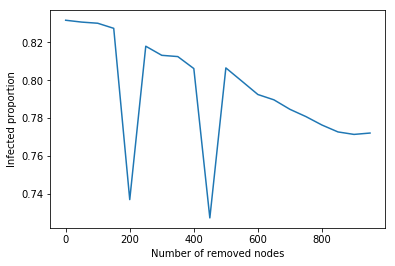

In [78]:
final_infection_states = np.array(extract_infection_states(by_betweenness_history))

plt.plot(final_infection_states[:,0], final_infection_states[:,1])
plt.xlabel('Number of removed nodes')
plt.ylabel('Infected proportion')
plt.show()

Here for comparison the simulation with 900 nodes removed, we can see that in the same amount of iterations, the virus only infects about 6% less of the globe.

In [130]:
new_g = by_betweenness_history[-1][1]
trends, iterations, model = simulate_SIS(new_g)
viz = DiffusionTrend(model, trends)
p = viz.plot(width=500, height=500)
p.legend.location = "center_right"
show(p)

In [96]:
nx.diameter(new_g)

24

In [97]:
nx.average_shortest_path_length(new_g)

4.459601395106095

In [98]:
average_degree(new_g)

8.729325805380272

In [131]:
makeMap(iterations)

### Removing edges

Stopping the epidemic by removing some nodes while keeping the connectedness property is feasible. However, a finer grain strategy might yield better results. Therefore, in the cell below, we investigate an edge alteration strategy, using the betweenness value of each edge.

In [100]:
class ByEdgeBetweennessAlterator: 
        
    def register(self, G):
        betweenness_centrality_per_edge = nx.edge_betweenness_centrality(G)
    
        self.ranked_edges = sorted(dict(betweenness_centrality_per_edge).keys(),\
                      key=lambda edge: -betweenness_centrality_per_edge[edge])
        
    def alter(self, G, i, initial_node):
        tmp_G = G.copy()
    
        alteration_level = 300*i
    
        for edge in self.ranked_edges[:alteration_level]:
            tmp_G.remove_edge(*edge)
            
            if not nx.is_connected(tmp_G):
                tmp_G.add_edge(*edge)

        return tmp_G, alteration_level

In [101]:
by_edge_betweenness_history = spread_reduction_experiment(giant_comp, simulate_e1_SIS, 20, 10,\
                                                          ByEdgeBetweennessAlterator(), 753)

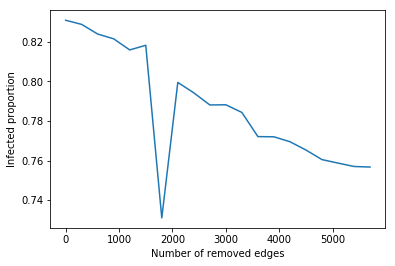

In [102]:
final_infection_states = np.array(extract_infection_states(by_edge_betweenness_history))

plt.plot(final_infection_states[:,0], final_infection_states[:,1])
plt.xlabel('Number of removed edges')
plt.ylabel('Infected proportion')
plt.show()

Here for comparison the simulation with 6000 edges removed, we can see that in the same amount of iterations, the virus infects about 7% less of the population.

In [132]:
new_g = by_edge_betweenness_history[-1][1]
trends, iterations, model = simulate_SIS(new_g)
viz = DiffusionTrend(model, trends)
p = viz.plot(width=500, height=500)
p.legend.location = "center_right"
show(p)

In [106]:
nx.diameter(new_g)

26

In [107]:
nx.average_shortest_path_length(new_g)

6.494619407236596

In [108]:
average_degree(new_g)

15.154947502386255

In [133]:
makeMap(iterations)

## Conclusion

To conclude we applied three different techniques to reduce de propagation of a very infectious disease through the airline network. It seems that removing edges based on the edge betweenness is the best solution, although it is increases harshly the average shortest path.